<a href="https://colab.research.google.com/github/lilz827/final-project-303-3/blob/main/Project%20Code%20Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Length of the code {-}
No restriction

**Delete this section from the report, when using this template.** 

## Data quality check / cleaning / preparation 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.** An example is given below.

### Distribution of response
*By Sylvia Sherwood*

In [ ]:
#...Plot for distribution of response...#

# Mean and standard deviation of response #

### Data cleaning
*By Sankaranarayanan Balasubramanian & Fiona Fe*

In [ ]:
#...Code with comments...#

# Imputing missing values #

### Data preparation
*By Ryu Kimiko*

The following data preparation steps helped us to prepare our data for implementing various modeling / validation techniques:

1. Since we need to predict house price, we derived some new predictors *(from existing predictors)* that intuitively seem to be helpuful to predict house price. 

2. We have created a standardized version of the dataset, as we will use it to develop Lasso / Ridge regression models.

In [ ]:
######---------------Creating new predictors----------------#########

#Creating number of bedrooms per unit floor area

#Creating ratio of bathrooms to bedrooms

#Creating ratio of carpet area to floor area

In [ ]:
######-----Standardizing the dataset for Lasso / Ridge-------#########

## Exploratory data analysis

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

## Developing the model: Hyperparameter tuning

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

Put each model in a section of its name and mention the name of the team-member tuning the model. Below is an example:

### RandomForest & AdaBoost
*By Lilly Sorkin*

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_recall_curve

data = pd.read_csv('stats_unique_no_missing.csv')
cols = list(data.columns)
categorical_cols = []
numerical_cols = []
for item in cols:
    if data[item].dtype == object:
        categorical_cols.append(item)
    else:
        numerical_cols.append(item)
data = data.set_index('player_name')
data = data.drop(['Unnamed: 64', 'Unnamed: 65', 'rimmade+rimmiss', 'midmade+midmiss',
       'dunksmiss+dunksmade', 'num', 'type'], axis=1)
data_dummies = pd.get_dummies(data)
y = data_dummies.drafted
X = data_dummies.drop('drafted', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=45, stratify=y)

In [2]:
# RandomForest hyperparameter selection
params = {'bootstrap': [True, False],
          'n_estimators': [10, 300, 500, 1000],
          'max_depth': [25, 30, 35],
          'max_leaf_nodes': [100, 500, 1000]}

model_group = GridSearchCV(RandomForestClassifier(random_state=45, n_jobs=-1),
                           params, scoring='recall',
                           cv=3, n_jobs=-1, verbose=1)

model_group.fit(X_train, y_train)
print(model_group.best_score_, model_group.best_params_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
0.18856339055958826 {'bootstrap': False, 'max_depth': 25, 'max_leaf_nodes': 1000, 'n_estimators': 500}


<Figure size 800x800 with 0 Axes>

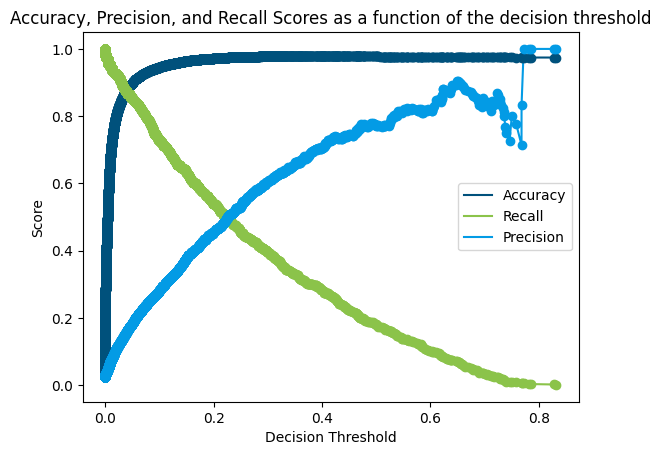

In [3]:
# RandomForest final model
model1 = RandomForestClassifier(random_state=45, bootstrap=False,
                               n_estimators=500, max_leaf_nodes=1000,
                               max_depth=25, n_jobs=-1)
model1.fit(X_train, y_train)

cross_val_ypred = cross_val_predict(model1, X_train, y_train, cv = 5, method = 'predict_proba')
p, r, thresholds = precision_recall_curve(y_train, cross_val_ypred[:,1])
accuracys = []
for threshold in thresholds:
    ypred = cross_val_ypred[:,1] > threshold
    ypred = ypred.astype(int)
    accuracy = accuracy_score(ypred, y_train)
    accuracys.append(accuracy)
accuracys = np.array(accuracys)     

def plot_accuracy_recall_vs_threshold(recalls, precisions, thresholds):
    plt.figure(figsize=(8, 8))
    plt.figure(facecolor='white')
    plt.title("Accuracy, Precision, and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, accuracys, "-", color="#00517c", label="Accuracy")
    plt.plot(thresholds, recalls[:-1], "-", color="#8bc34a", label="Recall")
    plt.plot(thresholds, precisions[:-1], "-", color="#039be5", label="Precision")
    plt.plot(thresholds, accuracys, "o", color="#00517c")
    plt.plot(thresholds, recalls[:-1], "o", color="#8bc34a")
    plt.plot(thresholds, precisions[:-1], "o", color="#039be5")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_accuracy_recall_vs_threshold(r, p, thresholds)

In [7]:
# RandomForest decision threshold and results
desired_threshold = 0.05

ypred_prob_train = model1.predict_proba(X_train)[:,1] 
ypred_train = ypred_prob_train > desired_threshold
ypred_train = ypred_train.astype(int)

ypred_prob_test = model1.predict_proba(X_test)[:,1] 
ypred_test = ypred_prob_test > desired_threshold
ypred_test = ypred_test.astype(int)

print("Train Accuracy: ", accuracy_score(y_train, ypred_train))
print("Train Recall: ", recall_score(y_train, ypred_train))
print("Test Accuracy: ", accuracy_score(y_test, ypred_test))
print("Test Recall: ", recall_score(y_test, ypred_test))

Train Accuracy:  1.0
Train Recall:  1.0
Test Accuracy:  0.8984964235317017
Test Recall:  0.8045540796963947


In [10]:
# AdaBoost hyperparameter selection
params = {'estimator': [DecisionTreeClassifier(max_depth=10),
                            DecisionTreeClassifier(max_depth=11),
                            DecisionTreeClassifier(max_depth=12)],
          'n_estimators': [5, 10, 50, 100],
          'learning_rate': [0.01, 0.02, 0.05]}

model_group = GridSearchCV(AdaBoostClassifier(random_state=45),
                           params, scoring='recall',
                           cv=3, n_jobs=-1, verbose=1)

model_group.fit(X_train, y_train)
print(model_group.best_score_, model_group.best_params_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
0.3911837001190614 {'estimator': DecisionTreeClassifier(max_depth=11), 'learning_rate': 0.05, 'n_estimators': 10}


<Figure size 800x800 with 0 Axes>

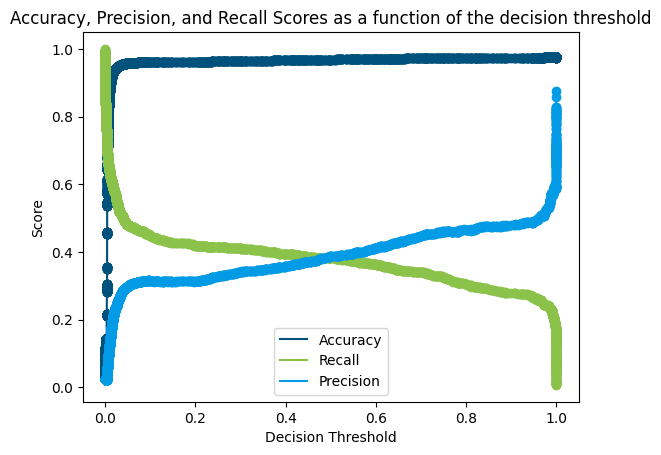

In [11]:
# AdaBoost final model
model2 = AdaBoostClassifier(random_state=45, estimator=DecisionTreeClassifier(max_depth=11),
                            n_estimators=10, learning_rate=0.05)
model2.fit(X_train, y_train)

cross_val_ypred = cross_val_predict(model2, X_train, y_train, cv = 5, method = 'predict_proba')
p, r, thresholds = precision_recall_curve(y_train, cross_val_ypred[:,1])
accuracys = []
for threshold in thresholds:
    ypred = cross_val_ypred[:,1] > threshold
    ypred = ypred.astype(int)
    accuracy = accuracy_score(ypred, y_train)
    accuracys.append(accuracy)
accuracys = np.array(accuracys)     

def plot_accuracy_recall_vs_threshold(recalls, precisions, thresholds):
    plt.figure(figsize=(8, 8))
    plt.figure(facecolor='white')
    plt.title("Accuracy, Precision, and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, accuracys, "-", color="#00517c", label="Accuracy")
    plt.plot(thresholds, recalls[:-1], "-", color="#8bc34a", label="Recall")
    plt.plot(thresholds, precisions[:-1], "-", color="#039be5", label="Precision")
    plt.plot(thresholds, accuracys, "o", color="#00517c")
    plt.plot(thresholds, recalls[:-1], "o", color="#8bc34a")
    plt.plot(thresholds, precisions[:-1], "o", color="#039be5")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_accuracy_recall_vs_threshold(r, p, thresholds)

In [17]:
# AdaBoost decision threshold and results
desired_threshold = 0.01

ypred_prob_train = model2.predict_proba(X_train)[:,1] 
ypred_train = ypred_prob_train > desired_threshold
ypred_train = ypred_train.astype(int)

ypred_prob_test = model2.predict_proba(X_test)[:,1] 
ypred_test = ypred_prob_test > desired_threshold
ypred_test = ypred_test.astype(int)

print("Train Accuracy: ", accuracy_score(y_train, ypred_train))
print("Train Recall: ", recall_score(y_train, ypred_train))
print("Test Accuracy: ", accuracy_score(y_test, ypred_test))
print("Test Recall: ", recall_score(y_test, ypred_test))

Train Accuracy:  0.8948580697485807
Train Recall:  1.0
Test Accuracy:  0.865262031044718
Test Recall:  0.6318785578747628


### MARS, AdaBoost & LightGBM
*By Sankaranarayanan Balasubramanian*

### Bagged trees & Random forest
*By Fiona Fe*

### XGBoost
*By Ryu Kimiko*

## Model Ensemble 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**


### Voting ensemble

### Stacking ensemble(s)

### Ensemble of ensembled models

### Innovative ensembling methods
*(Optional)*

## Conclusions and Recommendations to stakeholder(s)

You may or may not have code to put in this section. Delete this section if it is irrelevant.